In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
sns.set_theme()
sns.set_style('whitegrid')

def get_raw_results(cur_dir, skip=0, till=-1):
    with open(cur_dir, 'r') as file:
        elems = file.read().split('\n')[skip:till]
        elems = [float(e) for e in elems]
        return elems

def results_generator(l, basedir, skip=0, till=-1):
    for d in l:
        cur_dir = os.path.join(basedir, d)
        elems = get_raw_results(cur_dir, skip, till)
        m = sum(elems) / len(elems)
        yield m

In [3]:
def make_gemm_graph(ax, basedir, title, show_caches=True):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm_ddr_hbm')]
    numerical.sort()
    numerical = numerical[::]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr', skip=1))
    results2 = list(results_generator(l, basedir + '/hbm', skip=1))
    results3 = list(results_generator(l, basedir + '/hbm_hbm_ddr', skip=1))
    results4 = list(results_generator(l, basedir + '/ddr_ddr_hbm', skip=1))
    results5 = list(results_generator(l, basedir + '/hbm_ddr_ddr', skip=1))
    results6 = list(results_generator(l, basedir + '/hbm_ddr_hbm', skip=1))

    ax.set_xscale('log', base=2)
    ax.set_title(title)
    ax.set_xlabel('Per matrix size (bytes)')
    ax.set_ylabel('Throughput to out matrix (GB/s)')
    ax.plot(numerical, results1, 'o', label='DDR*DDR=DDR')
    ax.plot(numerical, results2, 'x', label='HBM*HBM=HBM')
    ax.plot(numerical, results3, 's', label='HBM*HBM=DDR')
    ax.plot(numerical, results4, '^', label='DDR*DDR=HBM')
    ax.plot(numerical, results5, '1', label='HBM*DDR=DDR')
    ax.plot(numerical, results6, '2', label='HBM*DDR=HBM')
    if show_caches:
        ax.axvline(x=65536, ls=':', label = 'CPU L1')
        ax.axvline(x=1048576, ls='-.', label = 'CPU L2')
        ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
        ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type')

def make_read_write_graph(ax, basedir, title, scalability=False, n_threads=1, rng=None, latency=False, show_caches=True, show_cpu=True, show_gpu=True, skip=1):
    numerical = [int(dir) for dir in os.listdir(basedir + '/hbm')]
    numerical.sort()
    if rng is not None:
        numerical = numerical[rng[0]:rng[1]]
    l = [str(dir) for dir in numerical]

    results1 = list(results_generator(l, basedir + '/ddr', skip=skip))
    results2 = list(results_generator(l, basedir + '/hbm', skip=skip))
    #results3 = list(results_generator(l, basedir + '/mmio', skip=0, till=1))

    #plt.figure(figsize=(6,4))
    if not scalability:
        ax.set_xscale('log', base=2)
    #ax.yscale('log', base=10)
    ax.set_title(title)
    if scalability:
        ax.set_xlabel('Num threads/blocks')
    else:
        ax.set_xlabel('Buffer Size (bytes)')
    if latency:
        ax.set_ylabel('Latency (ns)')
    else:
        ax.set_ylabel('Throughput (GB/s)')
    ax.plot(numerical, results1, 'o', label='DDR')
    ax.plot(numerical, results2, 'x', label='HBM')
    #ax.plot(numerical, results3, '.', label='MMIO')
    if not scalability and show_caches:
        if show_cpu:
            if n_threads > 1:
                ax.axvline(x=65536*n_threads, linestyle=(0, (1, 10)), label = f'CPU L1 x {n_threads}')
                ax.axvline(x=1048576*n_threads, linestyle=(0, (3, 10, 1, 10)), label = f'CPU L2 x {n_threads}')
            ax.axvline(x=65536, ls=':', label = f'CPU L1')
            ax.axvline(x=1048576, ls='-.', label = f'CPU L2')
            ax.axvline(x=119537664, ls='--', label = 'CPU L3')
        if show_gpu:
            ax.axvline(x=262144, ls=':', color='red', label = 'GPU L1')
            ax.axvline(x=52428800, ls='-.', color='red', label = 'GPU L2')
    ax.legend(title='Memory type', fontsize=8)

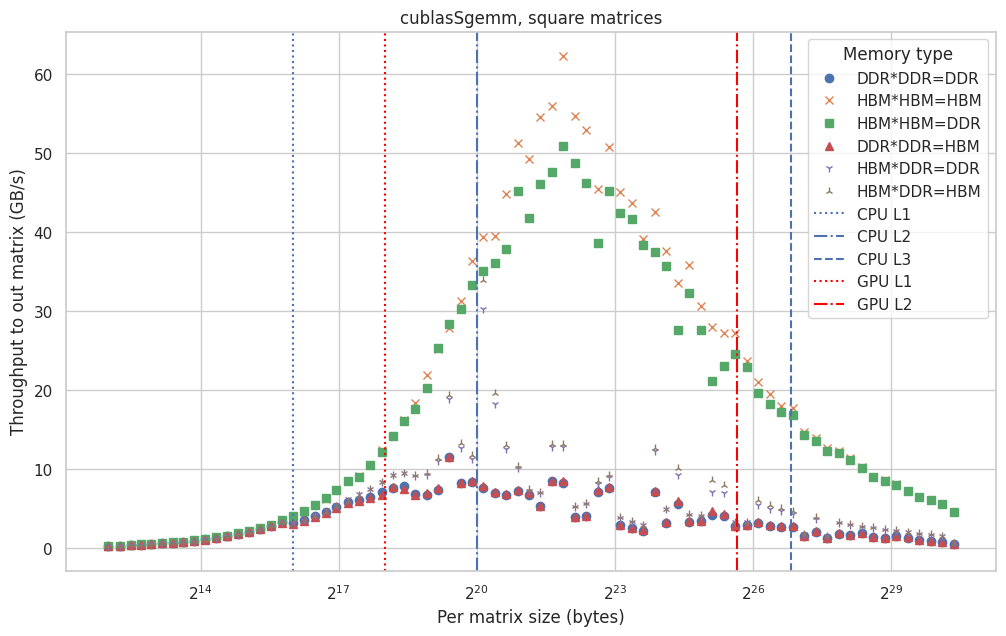

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
make_gemm_graph(ax, 'results/apps/gemm/cublas/', 'cublasSgemm, square matrices')

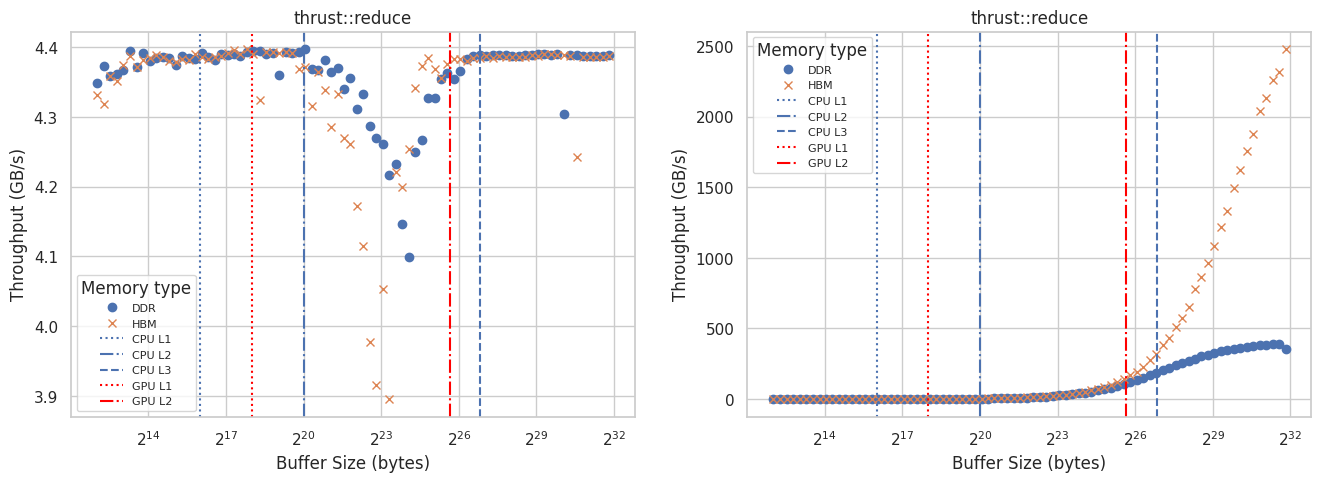

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
make_read_write_graph(ax1, 'results/apps/reduce/host', 'thrust::reduce')
make_read_write_graph(ax2, 'results/apps/reduce/device', 'thrust::reduce')